# MS003 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [6]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS003'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [7]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [8]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 110 x 1281024 (2502.0 s), ~1.05 GB, data loaded>

In [9]:
photodiode_data

<Raw | photodiode.fif, 1 x 1281024 (2502.0 s), ~9.8 MB, data loaded>

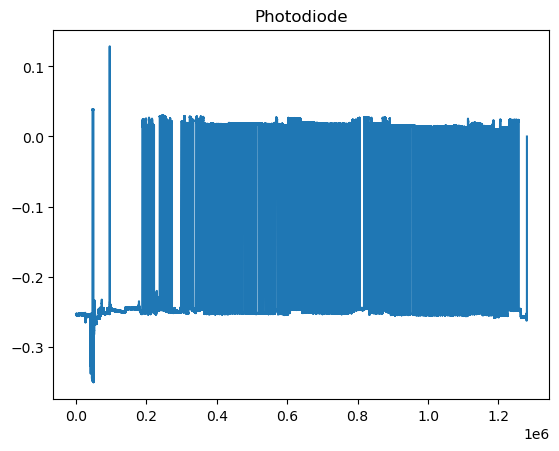

In [40]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [10]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A13_L,-3.709764,46.512775,-11.687440,-4.844184,33.999416,-13.071413,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN
1,LaCaS10,A9l_L,-7.308108,68.072344,28.268504,-9.890195,54.149132,36.376249,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Unknown,Left superior frontal gyrus 1 B,NaN
2,LaCaS11,A9l_L,-7.308108,70.467851,33.063217,-9.892679,56.415478,42.253481,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
3,LaCaS12,Unknown,-7.707924,71.665605,37.458371,-10.273735,57.347304,47.465558,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-4.109580,48.908282,-7.691846,-5.555517,36.209189,-7.914435,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,RsifO4,A1/2/3tonIa_R,45.467608,7.785400,15.882161,47.901761,-5.107676,15.077895,Gray,Right CO central operculum,Area OP3 [VS],R Rolandic Operculum,R PoG,Right somatosensory M,NaN,NaN
140,RsifO5,A1/2/3tonIa_R,50.665217,7.785400,16.281720,53.246638,-4.702719,15.720999,White,Right Cerebral White Matter,Unknown,R Rolandic Operculum,R PoG,Unknown,WM,NaN
141,RsifO6,A4hf_R,55.463009,7.785400,16.281720,58.186651,-4.353392,15.814696,White,Right Cerebral White Matter,Unknown,R Rolandic Operculum,R PrG,Right posterior motor J,WM,NaN
142,RsifO7,A1/2/3ulhf_R,60.660618,7.386149,16.681280,63.565237,-4.449542,16.441334,Gray,Right PoG postcentral gyrus,Area 3b,R Postcentral Gyrus,R PoG,Right somatosensory L,NaN,NaN


## Load behavior

In [11]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,97.0,gain,672.233587,672.243938,676.379679,678.399482,4.135741,0.6,0.00,...,0.000000,0.640499,0.359501,-0.800455,-0.800455,-0.687627,-0.800455,-0.687627,0.000000,0.000000
1,2,2.0,mix,683.445664,683.446437,686.689719,688.716539,3.243281,0.0,-0.30,...,-0.000207,0.607521,0.392479,0.000207,0.000000,0.085561,0.000000,0.000000,0.085768,0.085561
2,3,141.0,loss,692.985923,692.992102,697.634177,697.641242,4.642075,-0.6,-1.01,...,-0.000504,0.500235,0.499765,0.000000,-0.000184,-0.000184,0.000000,0.000000,-0.000184,-0.000184
3,4,90.0,gain,709.306608,709.307324,712.794498,712.801611,3.487175,0.5,0.00,...,0.000000,0.873370,0.126630,0.000000,0.601591,0.601591,0.000000,0.000000,0.601591,0.601591
4,5,22.0,mix,720.051674,720.059262,724.355490,726.382110,4.296228,0.0,-1.10,...,-0.000536,0.698602,0.301398,-0.164767,-0.165303,-0.000536,-0.165303,-0.000536,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,88.0,gain,2412.096003,2412.096821,2413.824209,2413.831479,1.727388,0.5,0.00,...,0.000000,0.702386,0.297614,0.000000,-0.167755,-0.167755,-0.167755,-0.167755,0.000000,0.000000
146,147,44.0,mix,2421.221671,2421.222379,2423.553517,2425.568175,2.331139,0.0,-1.10,...,-0.000536,0.939451,0.060549,-0.536188,-0.536724,-0.000536,-0.536724,-0.000536,0.000000,0.000000
147,148,82.0,gain,2436.098357,2436.104349,2440.013423,2440.020402,3.909074,0.5,0.00,...,0.000000,0.333812,0.666188,0.000000,0.134995,0.134995,0.134995,0.134995,0.000000,0.000000
148,149,4.0,mix,2447.536598,2447.537405,2449.974451,2451.994053,2.437046,0.0,-0.30,...,-0.000207,0.660769,0.339231,0.000207,0.000000,0.130459,0.000000,0.000000,0.130666,0.130459


In [12]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [13]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

11 blocks
...........

found matches for 120 of 170 pulses


## Make epochs

In [14]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [15]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [16]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [17]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 15419 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 16500 out of 16500 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 16434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 16500 out of 16500 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [18]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~193.7 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~322.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [19]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [20]:
epochs_all_evs[event].metadata

,lmolf9,lacas11,lacas12,racas12,lmcms1,lmcms6,lmcms10,rmcms6,rmcms10,laimm6,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.950,-0.950,-1.90,-0.60,-1.90,-0.60,0.00,0.00,0.800455,0.687627
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.105,0.195,0.00,0.09,0.00,0.00,0.39,0.09,0.085355,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.00,0.41,0.41,-0.000504,-0.000688
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-2.00,-2.00,0.00,0.00,0.50,0.50,0.978853,0.601591
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.440,-0.660,-1.32,-1.10,-1.32,-1.10,0.00,0.00,0.164231,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.30,-1.30,-1.30,-1.30,0.00,0.00,0.769346,0.601591
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,-1.100,-2.20,-1.10,-2.20,-1.10,0.00,0.00,0.535652,0.000000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.41,-0.41,-0.41,-0.41,0.00,0.00,0.466596,0.601591
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.070,0.230,0.00,0.16,0.00,0.00,0.46,0.16,0.130252,0.000000


### Save epoched data

In [21]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)